## Reading the data from the web into R

For our project, we will be needing to read the heart_disease.xlsx file, located in our data folder. To do this we will use read_excel from the readxl library that we will load alongside tidyverse, tidymodels and dplyr that can be used. We will be naming our data as heart_data.

In [42]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(dplyr)


In [43]:
heart_data <- read_excel("data/heart_disease.xlsx")

heart_data |>
slice(0:10)

age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal num
1  63  1   1  145      233  1   2       150     0     2.3     3     0  6    0  
2  67  1   4  160      286  0   2       108     1     1.5     2     3  3    2  
3  67  1   4  120      229  0   2       129     1     2.6     2     2  7    1  
4  37  1   3  130      250  0   0       187     0     3.5     3     0  3    0  
5  41  0   2  130      204  0   2       172     0     1.4     1     0  3    0  
6  56  1   2  120      236  0   0       178     0     0.8     1     0  3    0  
7  62  0   4  140      268  0   2       160     0     3.6     3     2  3    3  
8  57  0   4  120      354  0   0       163     1     0.6     1     0  3    0  
9  63  1   4  130      254  0   2       147     0     1.4     2     1  7    2  
10 53  1   4  140      203  1   2       155     1     3.1     3     0  7    1

With this data now loaded, we need to prepare it for processing before the application of our chosen method. The first change we will notice is that some values that are supposed to be read as numbers, are being read as characters. To change this we will need to use mutate to read these values as doubles instead of characters. We will take this chance to also use na.omit(), to remove any data that has non-existant data since we cannot use that for our predictions.

In [44]:
heart_data <- read_excel("data/heart_disease.xlsx") |>
                        mutate(ca = as.numeric(ca), thal = as.numeric(thal), num = as.factor(num)) |>
                        na.omit()

heart_data|>
slice(0:10)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `ca = as.numeric(ca)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal num
1  63  1   1  145      233  1   2       150     0     2.3     3     0  6    0  
2  67  1   4  160      286  0   2       108     1     1.5     2     3  3    2  
3  67  1   4  120      229  0   2       129     1     2.6     2     2  7    1  
4  37  1   3  130      250  0   0       187     0     3.5     3     0  3    0  
5  41  0   2  130      204  0   2       172     0     1.4     1     0  3    0  
6  56  1   2  120      236  0   0       178     0     0.8     1     0  3    0  
7  62  0   4  140      268  0   2       160     0     3.6     3     2  3    3  
8  57  0   4  120      354  0   0       163     1     0.6     1     0  3    0  
9  63  1   4  130      254  0   2       147     0     1.4     2     1  7    2  
10 53  1   4  140      203  1   2       155     1     3.1     3     0  7    1

## Creating the training and test set
In this section, the data will be split into a training and test set, so we are capable of training and then measuring the accuracy of our model. To do this, the data points will have to be randomly selected, based on a specific target outcome variable, so it can ensure that the distribution of the outcomes is equal, in this case that would be the column num. The prop data is 0.8 as we want to use only 80% of our data for training and keep the rest for testing. We set the seed as 9999 to keep results consistent across the board.

In [50]:
set.seed(9999)
heart_split <- initial_split(heart_data, prop = 0.70, strata = num)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

heart_train |>
    slice(0:5)
heart_test |> 
    slice(0:5)

age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal num
1 63  1   1  145      233  1   2       150     0     2.3     3     0  6    0  
2 37  1   3  130      250  0   0       187     0     3.5     3     0  3    0  
3 41  0   2  130      204  0   2       172     0     1.4     1     0  3    0  
4 56  1   2  120      236  0   0       178     0     0.8     1     0  3    0  
5 56  0   2  140      294  0   2       153     0     1.3     2     0  3    0

age sex cp trestbps chol fbs restecg thalach exang oldpeak slope ca thal num
1 67  1   4  160      286  0   2       108     1     1.5     2     3  3    2  
2 62  0   4  140      268  0   2       160     0     3.6     3     2  3    3  
3 57  0   4  120      354  0   0       163     1     0.6     1     0  3    0  
4 63  1   4  130      254  0   2       147     0     1.4     2     1  7    2  
5 53  1   4  140      203  1   2       155     1     3.1     3     0  7    1

We can now see that both the training and the test data not have different values, and are split into two different tibbles that we can use within our model.

## Summarizing training data

From here on out, we will only be using the training data for our analysis. First we will group our data by the column num, and then we summarise all numeric values and generate their means, so we can understand what the averages are for each different category.

In [51]:
summary_table <- heart_train |>
      group_by(num) |>
      summarise(across(where(is.numeric), list(mean = ~mean(.x, na.rm = TRUE))),
            Count = n())

summary_table

num age_mean sex_mean  cp_mean  trestbps_mean chol_mean fbs_mean  
1 0   51.98214 0.5446429 2.705357 128.2321      244.5000  0.15178571
2 1   55.25000 0.8333333 3.388889 131.0000      255.9722  0.05555556
3 2   56.41667 0.7500000 3.666667 135.7917      258.7917  0.29166667
4 3   57.83333 0.7500000 3.708333 138.7083      247.0000  0.29166667
5 4   59.20000 0.9000000 3.600000 138.6000      251.5000  0.10000000
  restecg_mean thalach_mean exang_mean oldpeak_mean slope_mean ca_mean  
1 0.8482143    157.9821     0.1160714  0.6178571    1.464286   0.2410714
2 0.9444444    145.9167     0.4166667  1.0027778    1.583333   0.8055556
3 0.6250000    137.0417     0.6250000  1.7833333    1.875000   1.1666667
4 1.3750000    131.7083     0.6250000  1.8083333    1.916667   1.7500000
5 1.5000000    141.7000     0.4000000  2.0700000    2.100000   1.6000000
  thal_mean Count
1 3.750000  112  
2 5.416667   36  
3 5.916667   24  
4 6.125000   24  
5 6.400000   10

With this data, it can be seen that the values for patients that come back negative for any heart disease (num = 0) have completely different means than the others. This shows an important pattern for us to understand what values to look at when categorizing whether or not a patient has some sort of heart disease. There are also other patterns within the table that show the differences between each diagnosis, which suggests that our model will also be able to accurately predict which diagnosis a patient has.

## Visualizing Training Data

Now that the data has been summarized, it is also important for it to be visualised. In this case, pivot_longer prepares the data for it to be used with facet_wrap during graph generation. With these graphs the distribution of the different predictors becomes clear, and that allows for us to see what data is continuous, and what data is discrete.

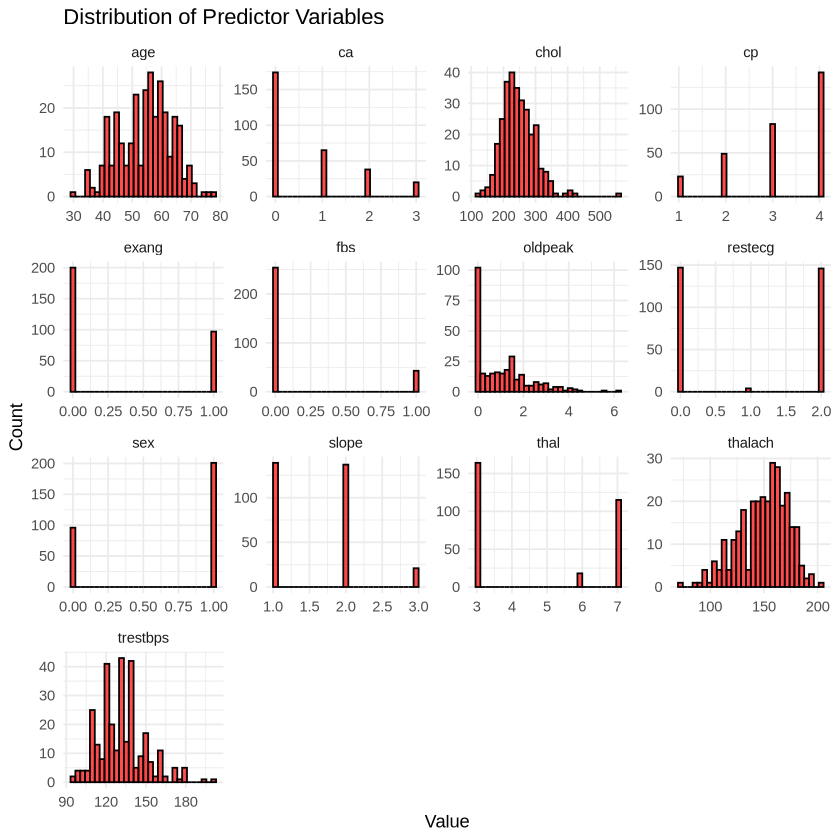

In [52]:
heart_data_long <- heart_data |>
  pivot_longer(cols = -num, names_to = "Predictor", values_to = "Value")

heart_data_long |>
ggplot(aes(x = Value)) +
  geom_histogram(bins = 30, fill = "red", color = "black", alpha = 0.7) +
  facet_wrap(~ Predictor, scales = "free") +
  labs(title = "Distribution of Predictor Variables",
       x = "Value", 
       y = "Count") +
      theme_minimal()

The graphs show the distribution of the different variables, and with this we are able to see which of the different predictor variables we will want to focus on. There are five predictors that stand out due to their continuous distribution, which are age, chol, oldpeak, thalach, trestbps. On the other hand, the variables ca, cp, exang, fbs, resetcg, sex, slope and thal are all discrete. This information allows us to see what variables we want to rely most on, as using continous data allows for a greater accuracy in our model.